In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings(action = 'ignore')
from sklearn.metrics import confusion_matrix,f1_score,roc_curve, auc, precision_recall_curve,accuracy_score
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut,LeavePOut # 数据集划分方法
from sklearn.model_selection import cross_val_score,cross_validate # 计算交叉验证下的测试误差
from sklearn import preprocessing
import sklearn.linear_model as LM
from sklearn import neighbors

(0.455, 1.01)

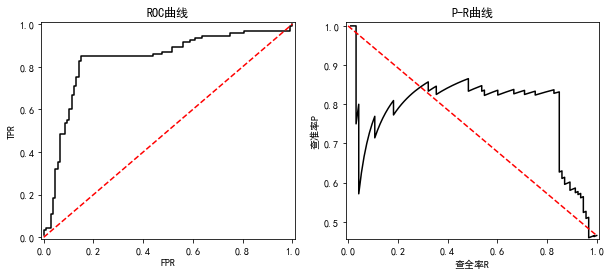

In [2]:
data = pd.read_csv('类别和概率.csv')
label=data['label']
prob=data['prob']
pos = np.sum(label == 1)
neg = np.sum(label == 0)
prob_sort = np.sort(prob)[::-1]
index = np.argsort(prob)[::-1]
label_sort = label[index]

Pre = []
Rec = []
tpr=[]
fpr=[]
for i, item in enumerate(prob_sort):
    Rec.append(np.sum((label_sort[:(i+1)] == 1)) /pos)
    Pre.append(np.sum((label_sort[:(i+1)] == 1))/(i+1))
    tpr.append(np.sum((label_sort[:(i+1)] == 1))/pos)
    fpr.append(np.sum((label_sort[:(i+1)] == 0)) /neg)

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axes[0].plot(fpr,tpr,'k')
axes[0].set_title('ROC曲线')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].plot([0, 1], [0, 1], 'r--')
axes[0].set_xlim([-0.01, 1.01])
axes[0].set_ylim([-0.01, 1.01])
axes[1].plot(Rec,Pre,'k')
axes[1].set_title('P-R曲线')
axes[1].set_xlabel('查全率R')
axes[1].set_ylabel('查准率P')
axes[1].plot([0,1],[1,pos/(pos+neg)], 'r--')
axes[1].set_xlim([-0.01, 1.01])
axes[1].set_ylim([pos/(pos+neg)-0.01, 1.01])

说明：
1、这里给出绘制ROC曲线和P-R曲线的示例。数据来自名为“类别和概率.csv”的文本文件，包括两列数据。第1列为模型预测为1类的概率值，第2列为实际标签（0或1）。
2、首先，计算实际标签为1和0类的样本量(pos和neg)；然后，将数据按概率值降序重新排列。
3、利用for循环计算绘图所需数据，FPR,TPR,查全率R和查准率P。循环中的i为索引，item为prob_sort的具体值（预测概率）。item值的重要应用是确定合理的概率阈值，应为TPR/FPR最大处的item值。这里采用enumerate() 函数，用于给出一个可遍历数据对象(如列表等）的索引和对应的数据。

训练误差: 0.07919847328244278
混淆矩阵:
 [[1128   76]
 [  90  802]]
F1-score: 0.9062146892655367
AUC: 0.9817750621992462
总正确率 0.9208015267175572


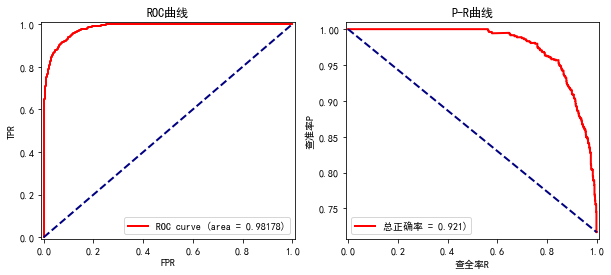

In [3]:
data=pd.read_excel('北京市空气质量数据.xlsx')
data=data.replace(0,np.NaN)
data=data.dropna()
data['有无污染']=data['质量等级'].map({'优':0,'良':0,'轻度污染':1,'中度污染':1,'重度污染':1,'严重污染':1})
data['有无污染'].value_counts()
X=data.loc[:,['PM2.5','PM10','SO2','CO','NO2','O3']]
Y=data.loc[:,'有无污染']

modelLR=LM.LogisticRegression()
modelLR.fit(X,Y)
print('训练误差:',1-modelLR.score(X,Y))  #print(accuracy_score(Y,modelLR.predict(X)))
print('混淆矩阵:\n',confusion_matrix(Y,modelLR.predict(X)))
print('F1-score:',f1_score(Y,modelLR.predict(X),pos_label=1))
fpr,tpr,thresholds = roc_curve(Y,modelLR.predict_proba(X)[:,1],pos_label=1) ###计算fpr和tpr
roc_auc = auc(fpr,tpr) ###计算auc的值
print('AUC:',roc_auc)
print('总正确率',accuracy_score(Y,modelLR.predict(X)))
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,4))
axes[0].plot(fpr, tpr, color='r',linewidth=2, label='ROC curve (area = %0.5f)' % roc_auc) 
axes[0].plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')
axes[0].set_xlim([-0.01, 1.01])
axes[0].set_ylim([-0.01, 1.01])
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('ROC曲线')
axes[0].legend(loc="lower right")

pre, rec, thresholds = precision_recall_curve(Y,modelLR.predict_proba(X)[:,1],pos_label=1)
axes[1].plot(rec, pre, color='r',linewidth=2, label='总正确率 = %0.3f)' % accuracy_score(Y,modelLR.predict(X))) 
axes[1].plot([0,1],[1,pre.min()],color='navy', linewidth=2, linestyle='--')
axes[1].set_xlim([-0.01, 1.01])
axes[1].set_ylim([pre.min()-0.01, 1.01])
axes[1].set_xlabel('查全率R')
axes[1].set_ylabel('查准率P')
axes[1].set_title('P-R曲线')
axes[1].legend(loc='lower left')
plt.show()

说明：
1、这里利用空气质量监测数据，建立Logistic回归模型对是否有污染进行分类预测。其中的输入变量包括PM2.5,PM10,SO2,CO,NO2,O3污染物浓度，是否有污染为二分类的输出变量（1为有污染，0为无污染）。进一步，对模型进行评价，涉及ROC曲线、AUC值以及F1分数等。需引用sklearn.metrics中的confusion_matrix,f1_score,roc_curve, auc，以及import accuracy_score等。
2、modelLR.score(X,Y)为预测模型的精度得分（基于训练集的）。分类预测的精度得分为总的预测正确率。也可通过accuracy_score函数得到同样结果。
3、confusion_matrix(Y,modelLR.predict(X))：计算模型的混淆矩阵。
4、f1_score(Y,modelLR.predict(X),pos_label=1)：针对1类计算F1得分。
5、modelLR.predict_proba(X)中存储模型预测为0类和1类的概率，这里关心预测为1类的概率。
6、roc_curve：计算预测为1类的概率从大到小过程中的TPR和FPR。auc(fpr,tpr) 计算ROC曲线下的面积。
7、precision_recall_curve：计算预测为1类的概率从大到小过程中的查准率P和查全率R.
8、ROC曲线和AUC值，以及P-R曲线均表明，该预测模型的预测误差（训练误差）很小。